In [62]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [63]:

# Load the dataset
train_df = pd.read_csv('kidney_train.csv')
test_df = pd.read_csv('kidney_test.csv')

X_train = train_df.drop('classification', axis=1)
y_train = train_df['classification'].map({'ckd': 1, 'notckd': 0})
X_test = test_df.drop('classification', axis=1)
y_test = test_df['classification'].map({'ckd': 1, 'notckd': 0})


In [64]:

# --- 2. Define Preprocessing ---
numeric_features = ['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']
categorical_features = ['rbc','pc','pcc','ba', 'htn','dm','cad','appet','pe','ane']



In [65]:
# Create sub-pipelines with Imputers 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [66]:

# --- 3. Build the Logistic Regression Pipeline ---
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])


In [67]:
log_reg_pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [68]:
def evaluate_model(model, X, y_true, model_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print(f"--- {model_name} Results ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_true, y_proba):.4f}")
    print("-" * 30)

# Execute Evaluation
evaluate_model(log_reg_pipeline, X_test, y_test, "Baseline Logistic Regression")

--- Baseline Logistic Regression Results ---
Accuracy:  0.9833
Precision: 1.0000
Recall:    0.9750
F1-Score:  0.9873
ROC-AUC:   1.0000
------------------------------


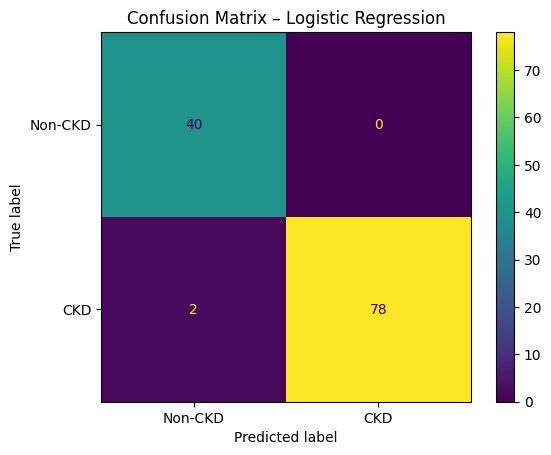

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions
y_pred_lr = log_reg_pipeline.predict(X_test)

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=["Non-CKD", "CKD"]
)

disp.plot()
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


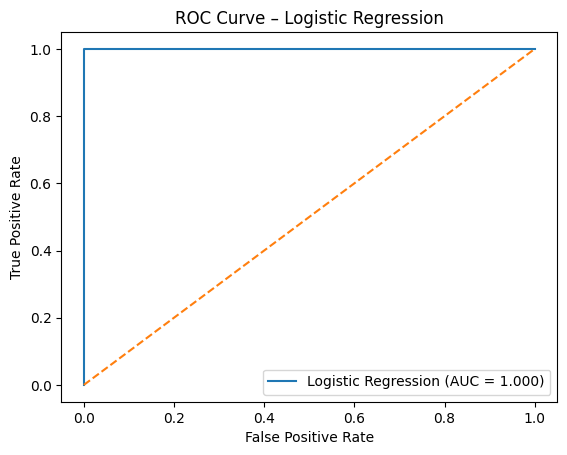

In [70]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilities
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()


In [71]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier

cat_cols = ['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

mlp = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", MLPClassifier(
        hidden_layer_sizes=(400,),
        alpha=0.001,
        early_stopping=True,
        max_iter=500,
        random_state=42
    ))
])

In [72]:
mlp.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [73]:
y_pred = mlp.predict(X_test)
y_proba = mlp.predict_proba(X_test)[:, 1]
y_pred_train= mlp.predict(X_train)

In [74]:
acc = accuracy_score(y_test, y_pred)
acc

0.95

In [75]:
trainacc = accuracy_score(y_train, y_pred_train)
trainacc

0.9642857142857143

In [76]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        40
           1       1.00      0.93      0.96        80

    accuracy                           0.95       120
   macro avg       0.93      0.96      0.95       120
weighted avg       0.96      0.95      0.95       120



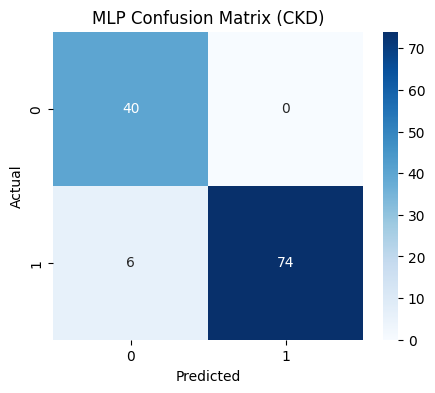

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("MLP Confusion Matrix (CKD)")
plt.show()

In [78]:
roc_auc = roc_auc_score(y_test, y_proba)
roc_auc

0.998125

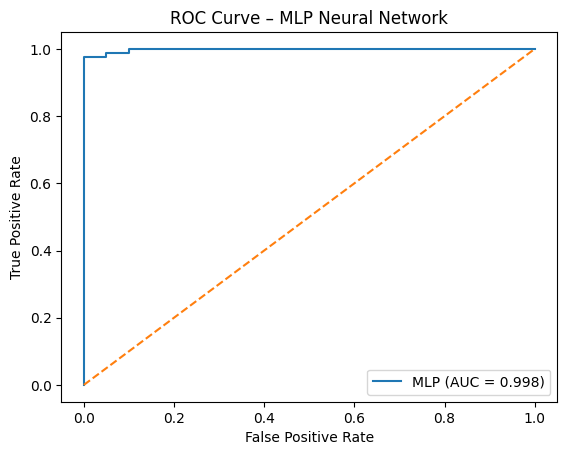

In [79]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilities
y_proba_mlp = mlp.predict_proba(X_test)[:, 1]

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_proba_mlp)
auc_mlp = roc_auc_score(y_test, y_proba_mlp)

plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {auc_mlp:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – MLP Neural Network")
plt.legend()
plt.show()

In [80]:
roc_auc_score(y_train, mlp.predict_proba(X_train)[:, 1])

0.9998930481283423

In [81]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = cross_val_score(mlp, X_train, y_train, cv=cv, scoring="roc_auc")
acc_scores = cross_val_score(mlp, X_train, y_train, cv=cv, scoring="accuracy")

print("CV ROC-AUC:", auc_scores.mean(), "+/-", auc_scores.std())
print("CV Acc:", acc_scores.mean(), "+/-", acc_scores.std())

CV ROC-AUC: 0.9994652406417112 +/- 0.0010695187165775447
CV Acc: 0.9428571428571428 +/- 0.042857142857142844


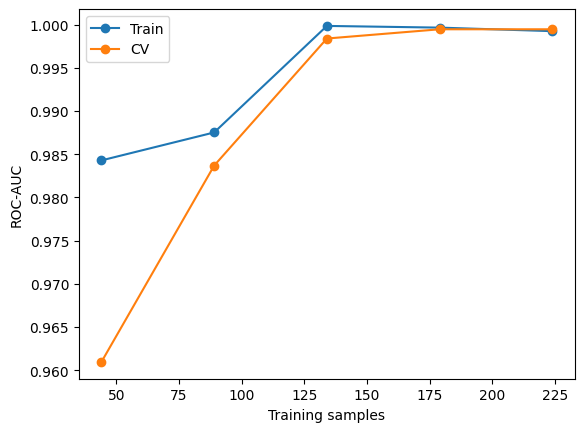

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    mlp, X_train, y_train,
    cv=cv,
    scoring="roc_auc",
    train_sizes=np.linspace(0.2, 1.0, 5),
    n_jobs=-1
)

plt.plot(train_sizes, train_scores.mean(axis=1), marker='o')
plt.plot(train_sizes, val_scores.mean(axis=1), marker='o')
plt.xlabel("Training samples")
plt.ylabel("ROC-AUC")
plt.legend(["Train", "CV"])
plt.show()

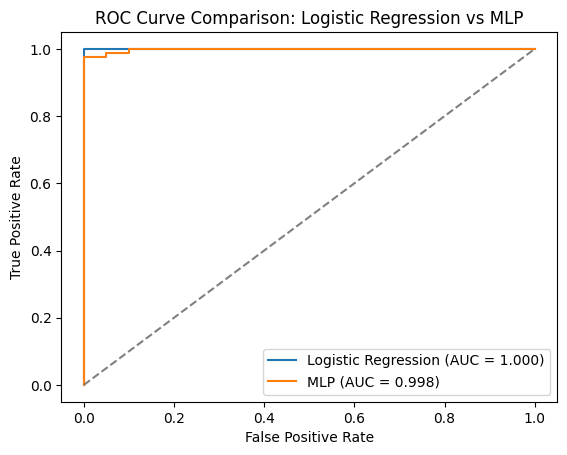

In [83]:
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {auc_mlp:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Logistic Regression vs MLP")
plt.legend()
plt.show()
